<a href="https://colab.research.google.com/github/alexlimatds/victor-doc_classification/blob/main/victor_doc_classification_CNN_error_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Error analysis of Document classification from Victor project using a CNN as machine learning model

The notebook analyzes errors commited by a CNN described in the _VICTOR: a Dataset for Brazilian Legal Documents Classification_ paper.

The CNN was trained in another notebook.

Deep learning library: PyTorch

### Instaling dependencies

In [ ]:
!pip install tqdm
!python -m spacy download pt

     |████████████████████████████████| 21.2MB 13.7MB/s 
  Created wheel for pt-core-news-sm: filename=pt_core_news_sm-2.2.5-cp36-none-any.whl size=21186283 sha256=63650cbab4b927c34a6df5ba97d35757fba10e75e4a070b3539733ba18c0aba9
  Stored in directory: /tmp/pip-ephem-wheel-cache-fm731nqz/wheels/ea/94/74/ec9be8418e9231b471be5dc7e1b45dd670019a376a6b5bc1c0
Successfully built pt-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/pt_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/pt
You can now load the model via spacy.load('pt')


### Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = '/content/gdrive/My Drive/'

Mounted at /content/gdrive


### Application parameters

In [ ]:
S = 500 # sentence length
BATCH_SIZE = 64
NUM_OF_CLASSES = 6

dataset_fraction = 0.1 # fraction of validation dataset to be used

MLP_HIDDEN_UNITS = 128
EMBEDDING_DIM = 100

dataset_dir = root_dir + 'Machine Learning/Victor datasets/'
model_path = dataset_dir + 'CNN/'
model_file = model_path + f'pytorch_model-{S}-{dataset_fraction}.pt'

### Loading and preprocessing datasets

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext import data
from tqdm.notebook import trange, tqdm_notebook
import numpy as np
from datetime import datetime

In [ ]:
if dataset_fraction == 1.0: # full dataset
  train_ds_file = 'train_small.csv'
  validation_ds_file = 'validation_small.csv'
else:
  train_ds_file = f'train_small.csv-croped_{dataset_fraction}.csv'
  validation_ds_file = f'validation_small.csv-croped_{dataset_fraction}.csv'

In [ ]:
import spacy

spacy_pt = spacy.load('pt')

def tokenizer(text):
  return [tok.text for tok in spacy_pt.tokenizer(text)]


In [ ]:
%%time

TEXT = data.Field(
    tokenize=tokenizer, 
    lower=True, 
    fix_length=S)
LABEL = data.Field(
    sequential=False, 
    unk_token=None)

# we must load the train dataset in order to get the same train's vocabulary
train_data, valid_data = data.TabularDataset.splits(
    path=dataset_dir, 
    train=train_ds_file,
    validation=validation_ds_file, 
    format='csv', 
    skip_header = True, 
    fields=[(None, None), (None, None), (None, None), ('label', LABEL), (None, None), ('text', TEXT)])

CPU times: user 40.2 s, sys: 512 ms, total: 40.8 s
Wall time: 42.8 s


In [ ]:
TEXT.build_vocab(train_data)
LABEL.build_vocab(train_data)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

_, valid_iterator = data.BucketIterator.splits(
  (train_data, valid_data),
  sort = False, #don't sort test/validation data
  batch_sizes=(BATCH_SIZE, BATCH_SIZE, BATCH_SIZE),
  device=device)

### Model

In [ ]:
class VictorCNN(nn.Module):

  def __init__(self, sentence_len, vocab_size, embed_dim, n_classes, mlp_h):
    """
    sentence_len: the length of the each input sentence.
    vocab_size:   the number of tokens in the vocabulary.
    embed_dim:    the dimension of each embedding word vector.
    n_classes:    number of classes, i.e., the output dimension of this NN.
    mlp_h:        number of hidden units of the MLP NN.
    """
    super(VictorCNN, self).__init__()
        
    self.word_embeddings = nn.Embedding(vocab_size, embed_dim)
    self.cnn_a = self.create_cnn_layer(embed_dim, 256, 3, 1)
    self.cnn_b = self.create_cnn_layer(embed_dim, 256, 4, 2)
    self.cnn_c = self.create_cnn_layer(embed_dim, 256, 5, 2)
    self.max_pool = nn.MaxPool1d(50)
    self.dropout = nn.Dropout(p=0.5)
    self.linear_h = nn.Linear(3840, mlp_h)
    self.linear_o = nn.Linear(mlp_h, n_classes)

  def create_cnn_layer(self, n_channels, n_filters, kernel_size, padding):
    return nn.Sequential(
        nn.Conv1d(n_channels, n_filters, kernel_size, padding=padding), 
        nn.BatchNorm1d(n_filters), 
        nn.MaxPool1d(2)
    )

  def forward(self, sentence):
    # sentence.shape: (s_len, b_len)
    embeds = self.word_embeddings(sentence).permute(1, 2, 0) # embeds shape: (b_len, embedding_dim, s_len)
    a = self.cnn_a(embeds)
    b = self.cnn_b(embeds)
    c = self.cnn_c(embeds)
    x = torch.cat((a, b, c), dim=1)
    x = self.max_pool(x)
    x = torch.flatten(x, start_dim=1)
    x = self.dropout(x)
    x = F.relu(self.linear_h(x))
    x = self.linear_o(x)
    return x

### Evaluation

In [ ]:
from sklearn.metrics import f1_score

def compute_metrics(targets, predictions):
  f1_macro = f1_score(targets, np.argmax(predictions, axis=1), average='macro')
  return f1_macro

def predict(model, iterator, set_name):
  model.eval()
  predictions = None
  targets = None
  with torch.no_grad():
    for batch in tqdm_notebook(iterator, desc=f'Predicting ({set_name})', unit='batch', leave=False):
      out = model(batch.text)
      if predictions == None:
        predictions = out
        targets = batch.label
      else:
        predictions = torch.cat([predictions, out], dim=0)
        targets = torch.cat([targets, batch.label], dim=0)
  
  return predictions.cpu().numpy(), targets.cpu().numpy()

def evaluate(model, iterator, set_name):  
  predictions, targets = predict(model, iterator, set_name)
  return compute_metrics(targets, predictions)


In [ ]:
def load_saved_model(file_name):
  m = VictorCNN(S, len(TEXT.vocab), EMBEDDING_DIM, NUM_OF_CLASSES, MLP_HIDDEN_UNITS)
  m = m.to(device)
  m.load_state_dict(torch.load(file_name, map_location=device))
  m.eval()
  return m

model = load_saved_model(model_file)

In [ ]:
predictions, targets = predict(model, valid_iterator, 'validation set')

                                  precision    recall  f1-score   support

                          outros     0.8481    0.8961    0.8714      8410
                   peticao_do_RE     0.8591    0.8702    0.8646      6364
agravo_em_recurso_extraordinario     0.8406    0.6994    0.7635      2149
                        sentenca     0.8985    0.8221    0.8586      1636
          acordao_de_2_instancia     0.9321    0.8261    0.8759       299
     despacho_de_admissibilidade     0.9119    0.7923    0.8480       183

                        accuracy                         0.8568     19041
                       macro avg     0.8817    0.8177    0.8470     19041
                    weighted avg     0.8572    0.8568    0.8557     19041



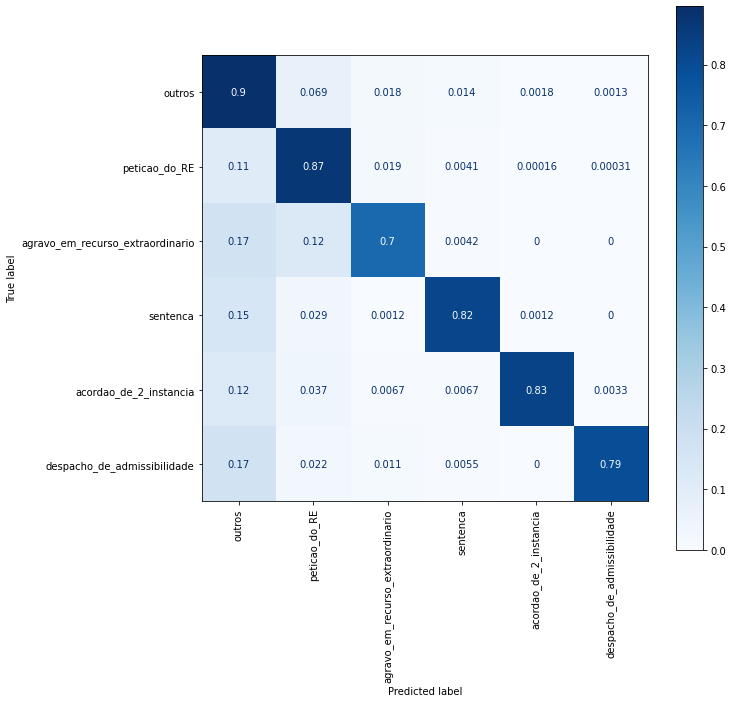

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix
cm = confusion_matrix(targets, np.argmax(predictions, axis=1), normalize='true')
f = plt.figure(figsize=(10,10))
ax = f.add_subplot()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABEL.vocab.itos)
disp.plot(xticks_rotation='vertical', cmap=plt.cm.Blues, ax=ax)

# Report
validation_report = classification_report(
    targets, 
    np.argmax(predictions, axis=1), 
    digits=4, 
    target_names=LABEL.vocab.itos)
print(validation_report)


References:

- https://medium.com/@rohit_agrawal/using-fine-tuned-gensim-word2vec-embeddings-with-torchtext-and-pytorch-17eea2883cd
